

<center><table>
<tr>

<th> <img src= "icons/INL1.png",align="middle",style="width: 10000px;"/> </th>
</tr>
<tr>
<th> <img src="icons/PennNucDataCenter.jpeg"  ,align="middle", style="width: 500px;"/> </th>
</tr>
<center><table>

# <center>Nuclear-Powered Data Centers Economic Optimization Strategy</center>

#### Expected Outcome
- A journal paper evaluating <u>the economic threshold points</u> identifying the conditions under which user requirements would be better suited by a large, small, or micro-reactor. The use case will be focused on data centers and will provide INL with the credential to stake a claim as a leader in nuclear for data center research.

- With a framework on hand, the lab could then leverage its expertise to offer advisory support for the various data centers considering nuclear energy. Further, with interest growing in this area, it is possible that DOE-NE would sponsor research on coupling nuclear reactors with data centers. INL would be well positioned to lead such R&D activities.

#### Activity
- A framework is proposed to evaluate the **economic tradeoff** between large, small, and micro-reactors. 
- The intent is to map out ‘threshold values’ under a given set of requirements 
  - energy demand size
  - reliability 
  
- The framework would parametrize a set of important economic variables to quantifiably differentiate the different reactor classes. 
  - nuclear capacity
  - diseconomies of scale, 
   - economies of mass production, 
   - speed of deployment, 
   - downtime intervals  



### Required Imports

In [1]:
#!/usr/local/bin/python3
import sys
from pathlib import Path
import numpy as np
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(1, str( (Path().absolute())  ) + "/src")

import matplotlib.pyplot as plt
from schedule_similar_reactors import calculate_duty_cycle_weeks_approach ,\
    calculate_schedule_multiple_reactors_weeks_approach, capacity_factor_weeks_approach, \
        num_reactors_needed_for_capacity_factor_weeks_apprioach
from parameters import fuel_cycle_length, refueling_duration_estimate, color_of
from economies_of_learning import calculate_break_even_cost_for_lr_per_demand
from schedule_mixed_reactor_optimizer import optimize_schedule
from parameters import power_large_ref, LR_for_power, power_large_ref


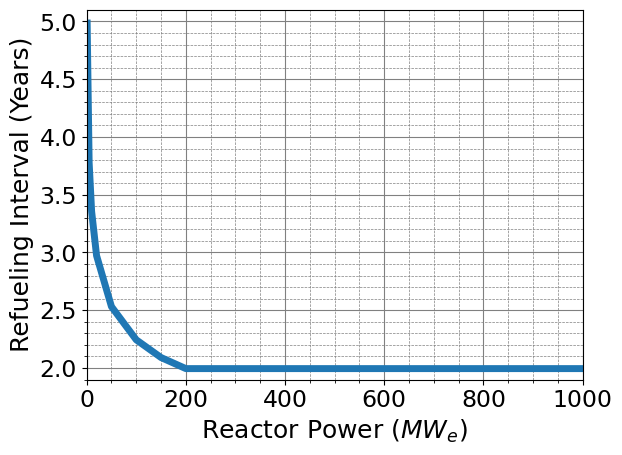

In [2]:
# How does the refueling interval look like
refuel_interval_list = []
power_list = [1, 5, 10, 20, 50, 100,150, 200, 300, 400 , 500, 1000]
for power in power_list:
    refuel_interval = fuel_cycle_length(power)
    refuel_interval_list.append(refuel_interval)

plt.plot( power_list, np.array(refuel_interval_list)/52.1429, linewidth=5.0)

plt.xlim(0, 1000)
plt.ylim(1.9, 5.1)
plt.xlabel('Reactor Power ($MW_e$)', fontsize=18) 
plt.ylabel('Refueling Interval (Years)', fontsize=18) 
# plt.xsc÷ale('log')
plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()

plt.yticks(fontsize=17)
plt.xticks(fontsize=17)




plt.savefig('results/refueling_interval.png', bbox_inches='tight')

# plt.show() 
    

## The schedule for one reactor

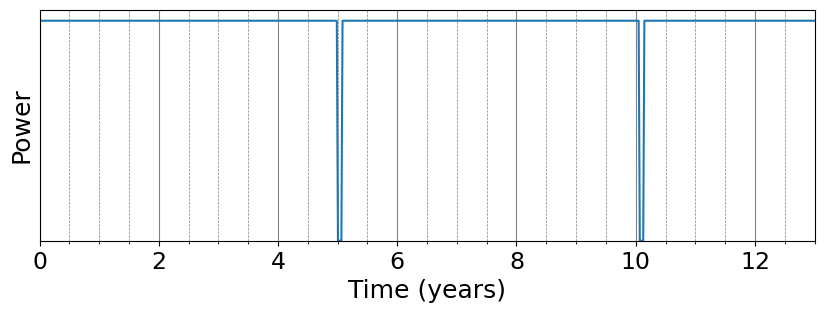

In [3]:
fig = plt.figure(figsize=(10, 3))
power = 1 # MWe
fuel_lifetime = fuel_cycle_length(power)
refueling_period = refueling_duration_estimate(power)
levelization_period = int((40*365)/7) # weeks
inital_delay = 0

t_list = []
P_list = []
for time in range(1, levelization_period+1):
    P = calculate_duty_cycle_weeks_approach( inital_delay, levelization_period, power, time)
    t_list.append(time)
    P_list.append(P)



plt.plot((np.array(t_list))/52.1429, P_list)
plt.xlim(0, 13)
plt.ylim(0, 1.05*power)
plt.xlabel('Time (years)', fontsize=18) 
plt.ylabel('Power', fontsize=18) 

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.yticks(fontsize=17)
plt.xticks(fontsize=17)



plt.savefig('results/schedule.png', bbox_inches='tight')

# plt.show()

## The schedule for 2 reactors
The second reactor should start after the first reactor with a delay equals 1 refueling period. This way we guarantee that:
1. Both reactors will never be off at the same time, 
2- Use the full power of the two reactors ASAP


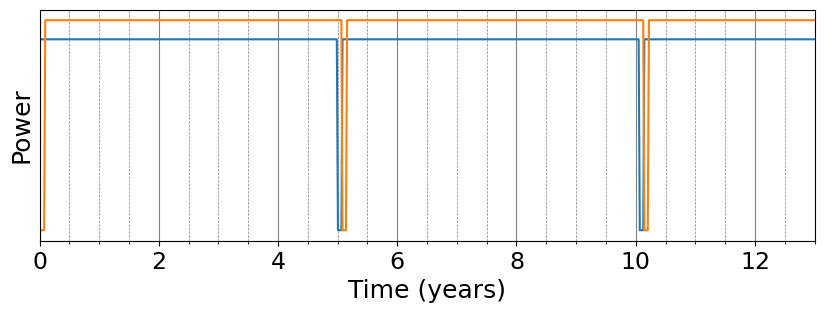

In [4]:
fig = plt.figure(figsize=(10, 3))

inital_delay1 = 0
inital_delay2 = refueling_period 

t_list = []
P_list1 = []
P_list2 = []
for time in range(1, levelization_period+1):
    P1 = calculate_duty_cycle_weeks_approach( inital_delay1,  levelization_period, power, time)
    t_list.append(time)
    P_list1.append(P1)
    P2 = calculate_duty_cycle_weeks_approach( inital_delay2,  levelization_period, power, time) # I change the power her for visualization
    if P2 == 0:
        if P1 ==0:
            print("WARNING: P2 = 0 and P1 =0")
    P_list2.append(P2)



plt.plot( np.array(t_list)/52.1429 , P_list1, label = "reactor #1")
plt.plot(np.array(t_list)/52.1429 , 1.1*np.array(P_list2), label = "reactor #2")
# plt.legend( loc='lower right' , fontsize=17)
plt.xlim(0, 13)


plt.xlabel('Time (years)', fontsize=18) 
plt.ylabel('Power', fontsize=18) 

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.yticks(fontsize=17)
plt.xticks(fontsize=17)

plt.gca().yaxis.set_major_locator(plt.NullLocator())

# plt.title(f"Refueling Schedule for two reactors \n Fuel Lifetime = {np.round(fuel_lifetime/365, 1)} years\
# , Refueling Period = {refueling_period} days  \n", fontsize=16)

plt.savefig('results/schedule_2.png', bbox_inches='tight')

plt.show()

## The schedule for multiple reactors : $ number \, of \, reactors  \le \frac{fuel \, Lifetime}{Refueling \, Period} $



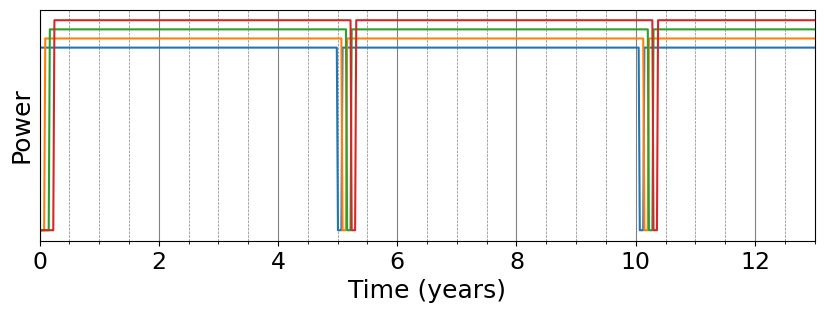

startup period  =  12.0 weeks


In [5]:
fig = plt.figure(figsize=(10, 3))

num_reactors = 4

initial_delay_list =list(refueling_period*np.linspace(0,  num_reactors-1, num_reactors) )
P_list_tot = []
for i in range(len(initial_delay_list)):
    
    delay = initial_delay_list[i] 
    
    t_list = []
    P_list = []

    for time in range(1, levelization_period+1):
       
        P = calculate_duty_cycle_weeks_approach( int( delay),  levelization_period, power, time)
      
        t_list.append(time)
        P_list.append(P)

    P_list_tot.append(P_list)

    plt.plot(np.array(t_list)/52.1429, (1+0.05*i)*np.array(P_list), label = f"reactor # {i+1}")
    # plt.legend( loc='lower right' , fontsize=15)
    plt.xlim(0, 13)


    plt.xlabel('Time (years)', fontsize= 18) 
    plt.ylabel('Power', fontsize=18) 

#     plt.title(f"Refueling Schedule for {num_reactors} reactors: \n Fuel Lifetime = {np.round(fuel_lifetime/365, 1)} years ,\
#     Refueling Period = {refueling_period} days  \n", fontsize=16)
plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()

plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig('results/schedule_4.png', bbox_inches='tight')

plt.show()

print( "startup period  = ", initial_delay_list[-1], "weeks")

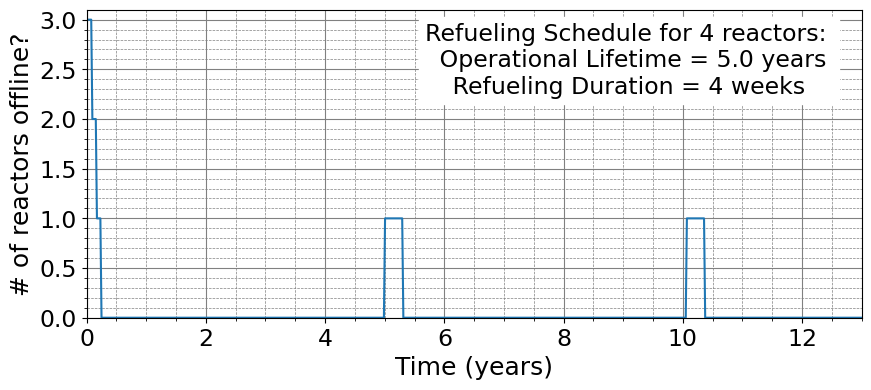

In [6]:
fig = plt.figure(figsize=(10, 4))

P_list_tot_array = (np.vstack(P_list_tot))
reactors_down_list = []
for n in range(P_list_tot_array.shape[1]):
    arr = P_list_tot_array[:,n]
    reactors_down_list.append(np.count_nonzero(arr==0))

plt.plot(np.array(t_list)/52.1429,  reactors_down_list) 
plt.xlabel('Time (years)', fontsize= 18) 
plt.ylabel('# of reactors offline?', fontsize= 18) 
plt.title(f"Refueling Schedule for {num_reactors} reactors: \n Operational Lifetime = {np.ceil(fuel_lifetime/52.1429)} years\n Refueling Duration = {refueling_period} weeks ", fontsize= 17,\
    x=0.7, y=0.7, backgroundcolor='white') 

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.xlim(0, 13)

plt.ylim(0, 3.1)

plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
plt.savefig('results/schedule_4_offline.png', bbox_inches='tight')

plt.show()

## The schedule for multiple reactors : $ number \, of \, reactors  > \frac{fuel \, Lifetime}{Refueling \, Period} $

An example for visualization (not realistic):
- fuel lifetime = 4 months
- refueling period = 1 months
- number of reactors = 7

Since the total number of refueling  = 1 months * 7 reactors = 7 months which is longer than the fuel lifetime which is 4 months, this means that more than one reactor has to be down at sometime

Using increments of 1 months (the refueling period), all the reactors have to be refueled within one cycle.
The number of reactos to be refueled at the same time $= \frac{7}{4}  = 1\frac{3}{4} $

-Therefore, 2 reactors will be refueled each month (in the first 3 months) and 1 reactor is refueled in the 4th month

<br>


This can be formulated as follows
- $number \, of\, reactors \, down \, at \, one\,  refueling\, period \in  [ Ceiling[ \frac {num \, of \, reactors \, \times \, refueling \, period}{ fuel \, lifetime}] \, , \, Floor[ \frac {num \, of \, reactors \, \times \, refueling \, period}{ fuel \, lifetime}]] $

    - The number of refueling period where the ceiling value is taken is :  $ \frac {modulus(num \, of \, reactors \, \times \, refueling \, period \, , \, refueling \, period) }{refueling \, period}$

# General Example (should work for any variables)

ramp up to full power period  =  256.0 weeks


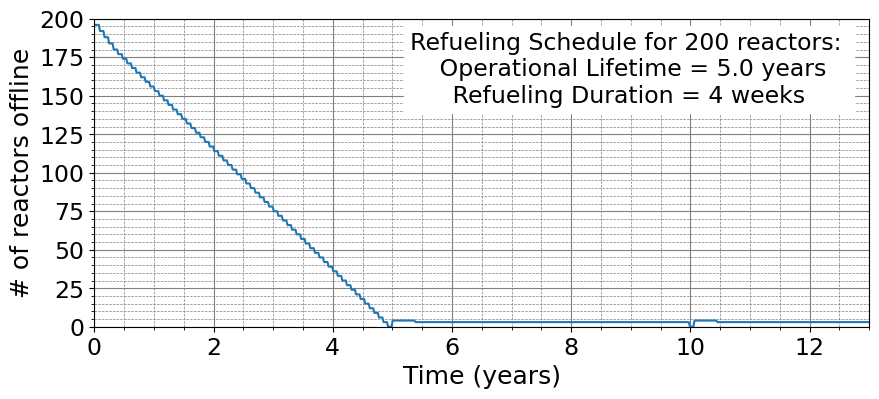

In [7]:
fig = plt.figure(figsize=(10, 4))
num_reactors = 200
power = 1 # MWe
schedule = calculate_schedule_multiple_reactors_weeks_approach( num_reactors, power, levelization_period) 
times =  schedule[0]
powers =  schedule[1]




P_list_tot_array = (np.vstack(powers))

reactors_down_list = []
for n in range(P_list_tot_array.shape[1]):
    arr = P_list_tot_array[:,n]
    reactors_down_list.append(np.count_nonzero(arr==0))


plt.plot(np.array(times)/52.1428,  reactors_down_list) 
# plt.yscale('log')

plt.xlabel('Time (years)', fontsize=18)
plt.ylabel('# of reactors offline', fontsize=18)

plt.title(f"Refueling Schedule for {num_reactors} reactors: \n Operational Lifetime = {np.ceil(fuel_lifetime/52.1429)} years\n Refueling Duration = {refueling_period} weeks ", fontsize= 17,\
    x=0.69, y=0.7, backgroundcolor='white') 


plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)

plt.minorticks_on()
plt.xlim(0, 13) # 
plt.ylim(0, 200)

print( "ramp up to full power period  = ", schedule[2], "weeks")
plt.savefig(f'results/schedule_200_offline.png', bbox_inches='tight')
plt.show()


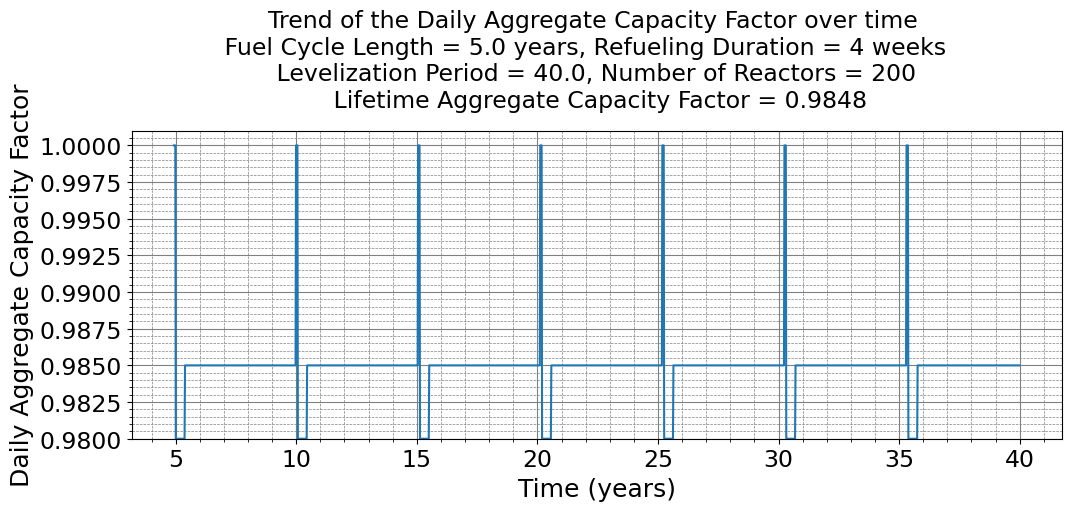

In [8]:
fig = plt.figure(figsize=(12, 4))


capacity_factor_results = capacity_factor_weeks_approach( num_reactors, power,levelization_period , power*num_reactors)
capacity_factor_results_time = capacity_factor_results[0]
capacity_factor_results_CF = capacity_factor_results[1]
capacity_factor_results_lifetime = capacity_factor_results[2]

plt.plot(np.array(capacity_factor_results_time)/52.1428571429  , capacity_factor_results_CF)

plt.xlabel('Time (years)', fontsize=18)
plt.ylabel('Daily Aggregate Capacity Factor', fontsize=18)

plt.title(f"Trend of the Daily Aggregate Capacity Factor over time \n Fuel Cycle Length = {np.ceil(fuel_lifetime/52.1429)} years, Refueling Duration = {refueling_period} weeks\
    \n Levelization Period = {np.ceil(levelization_period/52.1429)}, Number of Reactors = {num_reactors} \n Lifetime Aggregate Capacity Factor = {np.round(capacity_factor_results_lifetime,4)}", fontsize= 17,\
    x=0.5, y= 1.05, backgroundcolor='white') 

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.yticks(fontsize= 17)
plt.xticks(fontsize= 17)

# plt.xlim(0, 13) # 
plt.ylim(0.98, 1.001)

plt.minorticks_on()
plt.savefig(f'results/capacity_factor_200_offline.png', bbox_inches='tight')

plt.show()

# Daily Aggregate Capacity Factor  & Lifetime Aggregate Capacity Factor Criteria

In [10]:
# number of reactors to achieve the target demand 

levelization_period = int(np.ceil(40*365/7))


demand_0 = 10000 # MWe
power_list = [1000, 500, 300, 200, 100  ,50, 20, 5 , 1]
capacity_factor_criteria_list = [ 0.9, 0.93, 0.96, 0.97, 0.98, 0.99, 0.999 , 1]

num_R_per_capacity_factor_list_powers = []
for power in power_list :
    print('Reactor Size (MWe) : ', power)
    
    fuel_lifetime = fuel_cycle_length(power)
    refueling_period = refueling_duration_estimate(power)
    
    num_R_per_capacity_factor_list = []
    for capacity_factor_criteria in capacity_factor_criteria_list :
        num_R = num_reactors_needed_for_capacity_factor_weeks_apprioach(capacity_factor_criteria, 0, power, levelization_period, demand_0 )
        
        num_R_per_capacity_factor_list.append(num_R)
    num_R_per_capacity_factor_list_powers.append(num_R_per_capacity_factor_list)

Reactor Size (MWe) :  1000
Reactor Size (MWe) :  500
Reactor Size (MWe) :  300
Reactor Size (MWe) :  200
Reactor Size (MWe) :  100
Reactor Size (MWe) :  50
Reactor Size (MWe) :  20
Reactor Size (MWe) :  5
Reactor Size (MWe) :  1


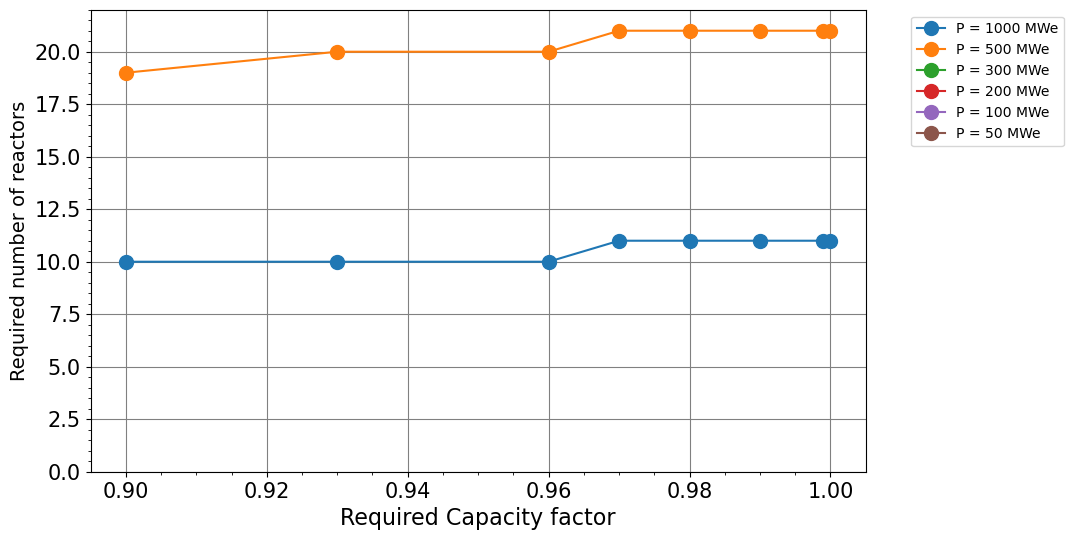

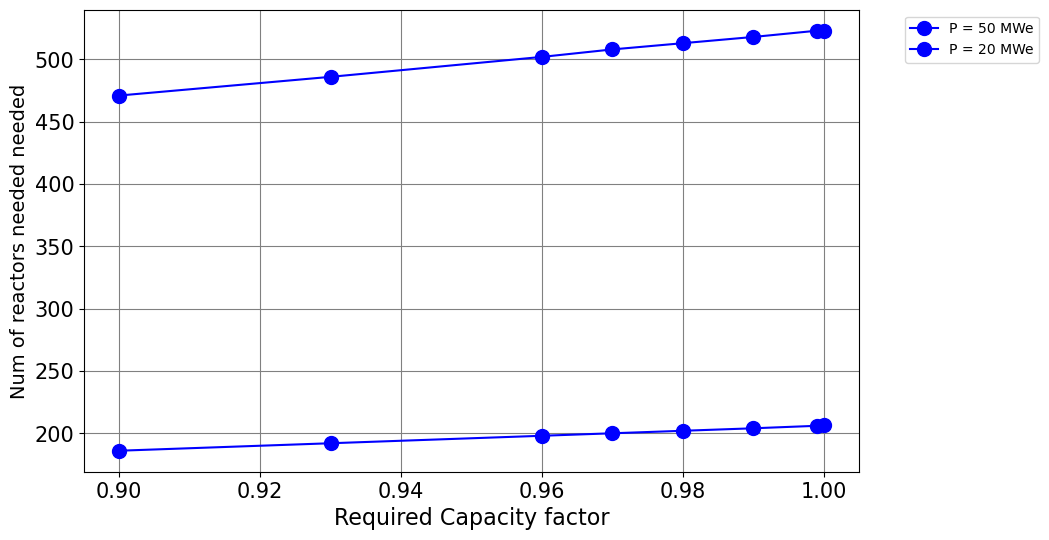

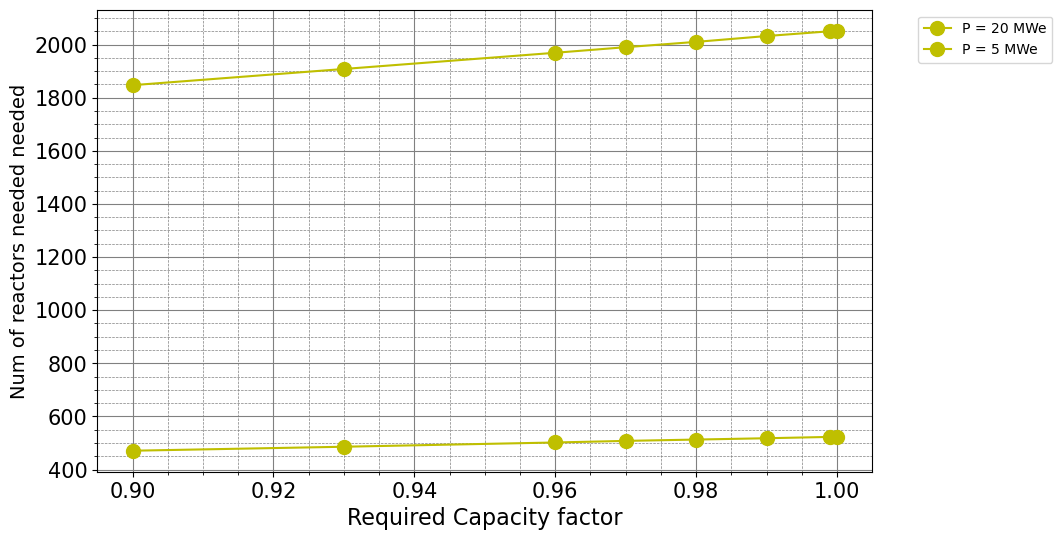

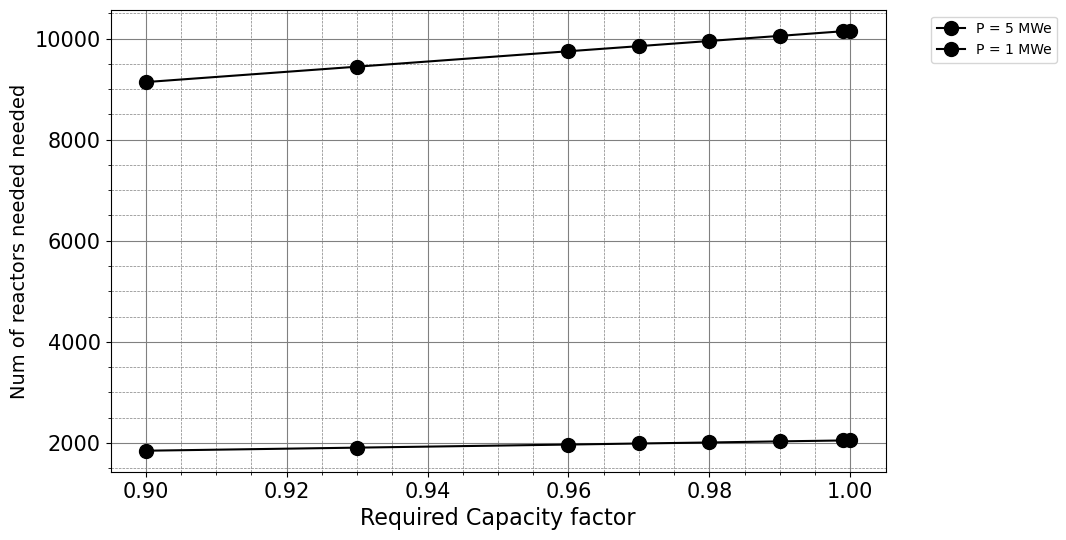

In [11]:

fig = plt.figure(figsize=(10, 6))


for i in range(len(num_R_per_capacity_factor_list_powers) - 3):
    plt.plot(capacity_factor_criteria_list, num_R_per_capacity_factor_list_powers[i], '-o' , markersize = 10, label =f'P = {power_list[i]} MWe')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.ylim(0, 22)


plt.xlabel('Required Capacity factor',  fontsize=16 )
plt.ylabel('Required number of reactors',  fontsize=14)


plt.grid(which='major', color='grey', linewidth=0.8)
# plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)  
plt.show()




fig = plt.figure(figsize=(10, 6))


for i in range(5, len(num_R_per_capacity_factor_list_powers) -2):
    # plt.yscale('log')
    plt.plot(capacity_factor_criteria_list, num_R_per_capacity_factor_list_powers[i], '-o' , markersize = 10, color = 'b',label =f'P = {power_list[i]} MWe')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

# plt.ylim(0, 12)


plt.xlabel('Required Capacity factor',  fontsize=16 )
plt.ylabel('Num of reactors needed needed',  fontsize=14)

# plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))




plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
# plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)  
plt.show()

fig = plt.figure(figsize=(10, 6))
for i in range(6, len(num_R_per_capacity_factor_list_powers) -1):
    # plt.yscale('log')
    plt.plot(capacity_factor_criteria_list, num_R_per_capacity_factor_list_powers[i], '-o' , markersize = 10, color = 'y',label =f'P = {power_list[i]} MWe')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


plt.xlabel('Required Capacity factor',  fontsize=16 )
plt.ylabel('Num of reactors needed needed',  fontsize=14)

# 
plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)  
plt.show()





fig = plt.figure(figsize=(10, 6))
for i in range(7, len(num_R_per_capacity_factor_list_powers) ):
    # plt.yscale('log')
    plt.plot(capacity_factor_criteria_list, num_R_per_capacity_factor_list_powers[i], '-o' , markersize = 10, color = 'k',label =f'P = {power_list[i]} MWe')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


plt.xlabel('Required Capacity factor',  fontsize=16 )
plt.ylabel('Num of reactors needed needed',  fontsize=14)



plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)  
plt.savefig(f'results/num_reactors_for_overall_capacity_factor_{demand_0}.png', bbox_inches='tight')

plt.show()





# Minimum Capacity Factor

In [13]:
# number of reactors to achieve the target demand 
min_capacity_factor_criteria_list = [ 0.9, 0.93, 0.96, 0.97, 0.98, 0.99, 0.999 , 1]

num_R_per_min_capacity_factor_list_powers = []

for power in power_list :
    print('REactor Size (MWe) :', power)
    fuel_lifetime = fuel_cycle_length(power)
    refueling_period = refueling_duration_estimate(power)
    
    num_R_per_min_capacity_factor_list = []
    for min_capacity_factor_criteria in min_capacity_factor_criteria_list  :
        
        num_R_min = num_reactors_needed_for_capacity_factor_weeks_apprioach(0, min_capacity_factor_criteria, power, levelization_period, demand_0 )
        num_R_per_min_capacity_factor_list.append(num_R_min)
        
    num_R_per_min_capacity_factor_list_powers.append(num_R_per_min_capacity_factor_list) 




REactor Size (MWe) : 1000
REactor Size (MWe) : 500
REactor Size (MWe) : 300
REactor Size (MWe) : 200
REactor Size (MWe) : 100
REactor Size (MWe) : 50
REactor Size (MWe) : 20
REactor Size (MWe) : 5
REactor Size (MWe) : 1


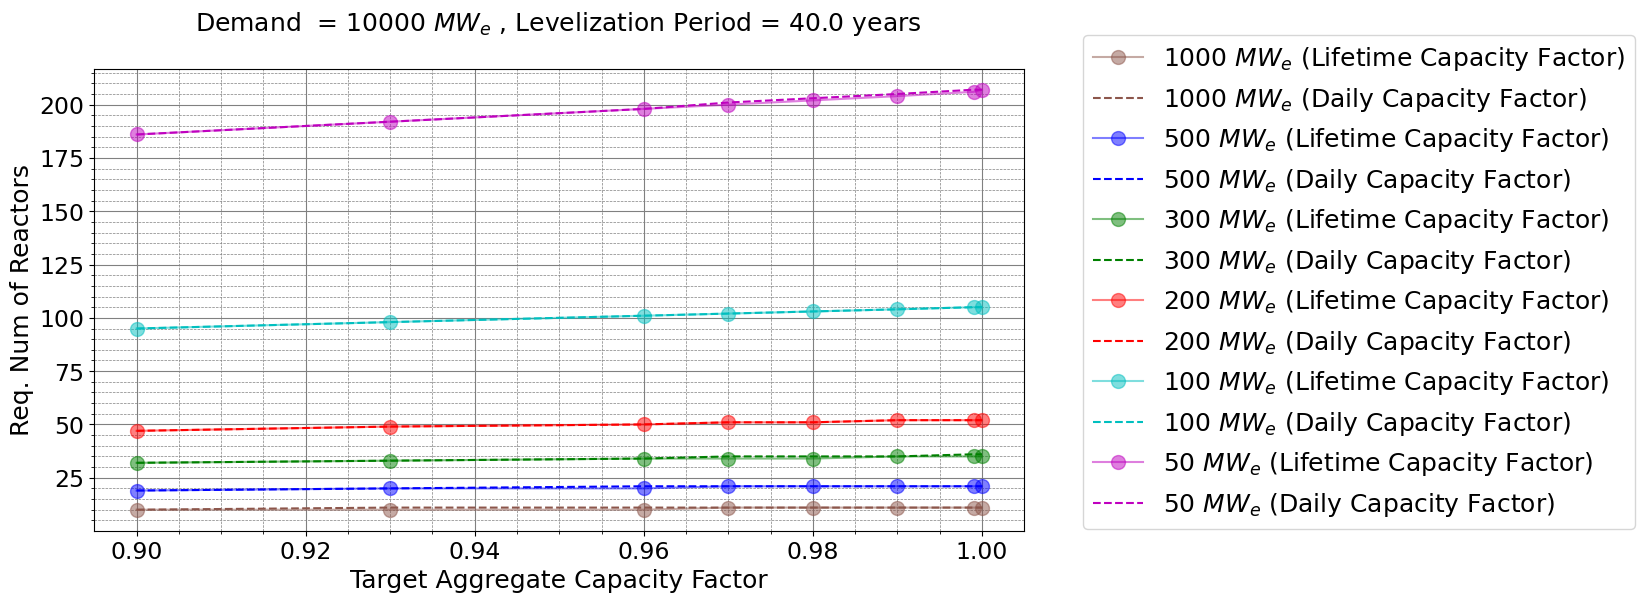

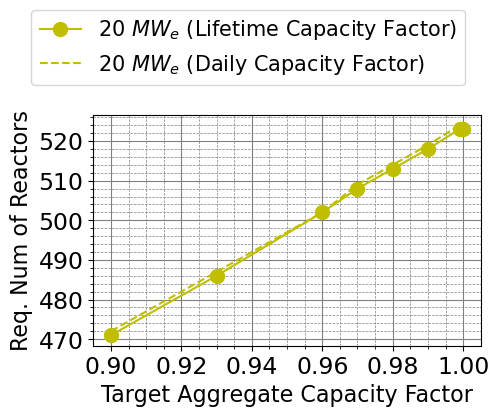

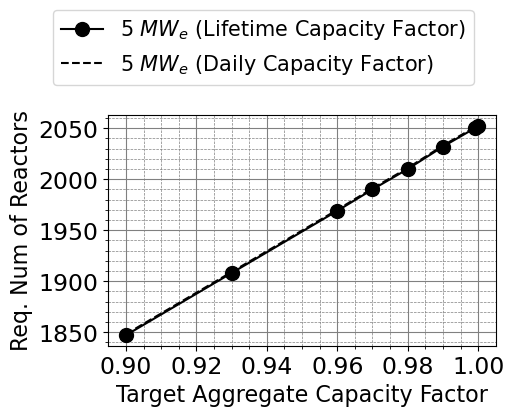

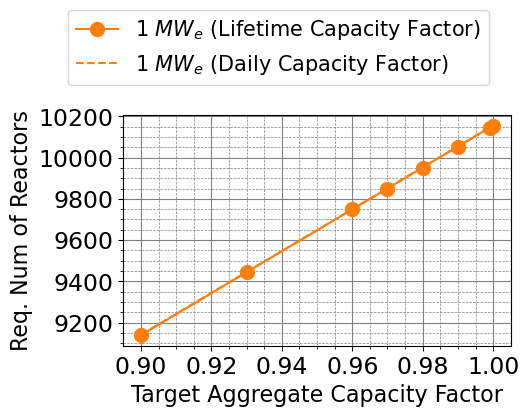

In [14]:
fig = plt.figure(figsize=(12, 6))



for i in range(6):
    plt.plot(capacity_factor_criteria_list, num_R_per_capacity_factor_list_powers[i], '-o' , markersize = 10, color = color_of(power_list[i]) ,alpha=0.5, label =f'{power_list[i]} $MW_e$ (Lifetime Capacity Factor)')
    plt.plot(min_capacity_factor_criteria_list, num_R_per_min_capacity_factor_list_powers[i], linestyle = 'dashed', color = color_of(power_list[i]),label =f'{power_list[i]} $MW_e$ (Daily Capacity Factor)')
    plt.legend(bbox_to_anchor=(1.05, 1.1), loc='upper left', fontsize=18 )

# plt.ylim(0, 22)


plt.xlabel('Target Aggregate Capacity Factor',  fontsize=18 )
plt.ylabel('Req. Num of Reactors',  fontsize=18)

plt.title( f"Demand  = {demand_0} $MW_e$ , Levelization Period = {np.round (levelization_period/52.1428571429, 1) } years \n  ",  fontsize=18)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=17)
plt.xticks(fontsize=17) 
# plt.gca().yaxis.set_major_locator(plt.MultipleLocator(5))
plt.savefig('results/num_reactors_to_satisfy_reliability1.png', bbox_inches='tight')

plt.show()




fig = plt.figure(figsize=(5, 3))

for i in range(6, 7):
    
    plt.plot(capacity_factor_criteria_list, num_R_per_capacity_factor_list_powers[i], '-o' , markersize = 10, color = color_of(power_list[i]) ,label =f'{power_list[i]} $MW_e$ (Lifetime Capacity Factor)')
    plt.plot(min_capacity_factor_criteria_list, num_R_per_min_capacity_factor_list_powers[i],linestyle = 'dashed', color = color_of(power_list[i]),label =f'{power_list[i]} $MW_e$ (Daily Capacity Factor)')
    plt.legend(bbox_to_anchor=(0.4, 1.5),loc='upper center', fontsize=15 )

# # plt.ylim(0, 12)


plt.ylabel('Req. Num of Reactors',  fontsize=16)
plt.xlabel('Target Aggregate Capacity Factor',  fontsize=16 )

# plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))


# plt.title(f"The number of reactors needed at each power level to satisfy the capacity factor: \n Fuel Lifetime = {np.round(fuel_lifetime/30, 1)} months ,   Refueling Period = {refueling_period} days ,\
#      Levelization Period = {np.round(levelization_period/365, 1)} years \n Demand  = {demand_0} MWe ",  fontsize=16)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)  
plt.savefig('results/num_reactors_to_satisfy_reliability2.png', bbox_inches='tight')

plt.show()



fig = plt.figure(figsize=(5, 3))
for i in range(7, 8):

    plt.plot(capacity_factor_criteria_list, num_R_per_capacity_factor_list_powers[i], '-o' , markersize = 10, color = color_of(power_list[i]),label =f'{power_list[i]} $MW_e$ (Lifetime Capacity Factor)')
    plt.plot(min_capacity_factor_criteria_list, num_R_per_min_capacity_factor_list_powers[i],linestyle = 'dashed', color = color_of(power_list[i]),label =f'{power_list[i]} $MW_e$ (Daily Capacity Factor)')

    plt.legend(bbox_to_anchor=(0.4, 1.5),loc='upper center', fontsize=15 )


plt.xlabel('Target Aggregate Capacity Factor',  fontsize=16 )
plt.ylabel('Req. Num of Reactors',  fontsize=16)

# plt.title(f"The number of reactors needed at each power level to satisfy the capacity factor: \n Fuel Lifetime = {np.round(fuel_lifetime/30, 1)} months ,   Refueling Period = {refueling_period} days ,\
#      Levelization Period = {np.round(levelization_period/365, 1)} years \n Demand  = {demand_0} MWe ",  fontsize=16)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)  
# plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))
plt.savefig(f'num_reactors_to_satisfy_reliability3.png', bbox_inches='tight')
plt.savefig('results/num_reactors_to_satisfy_reliability3.png', bbox_inches='tight')

plt.show()





fig = plt.figure(figsize=(5, 3))
for i in range(8, 9):

    plt.plot(capacity_factor_criteria_list, num_R_per_capacity_factor_list_powers[i], '-o' , markersize = 10, color = color_of(power_list[i]),label =f'{power_list[i]} $MW_e$ (Lifetime Capacity Factor)')
    plt.plot(min_capacity_factor_criteria_list, num_R_per_min_capacity_factor_list_powers[i],linestyle = 'dashed',color = color_of(power_list[i]),label =f'{power_list[i]} $MW_e$ (Daily Capacity Factor)')
    plt.legend(bbox_to_anchor=(0.4, 1.5),loc='upper center', fontsize=15 )


plt.xlabel('Target Aggregate Capacity Factor',  fontsize=16 )
plt.ylabel('Req. Num of Reactors',  fontsize=16)

# plt.title(f"The number of reactors needed at each power level to satisfy the capacity factor: \n Fuel Lifetime = {int(np.round(fuel_lifetime/30/12, 1))} years ,   Refueling Period = {refueling_period} days ,\
#      Levelization Period = {np.round(levelization_period/365, 1)} years \n Demand  = {demand_0} MWe ",  fontsize=16)

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)  
# plt.gca().yaxis.set_major_locator(plt.MultipleLocator(5))

plt.savefig('results/num_reactors_to_satisfy_reliability24.png', bbox_inches='tight')

plt.show()



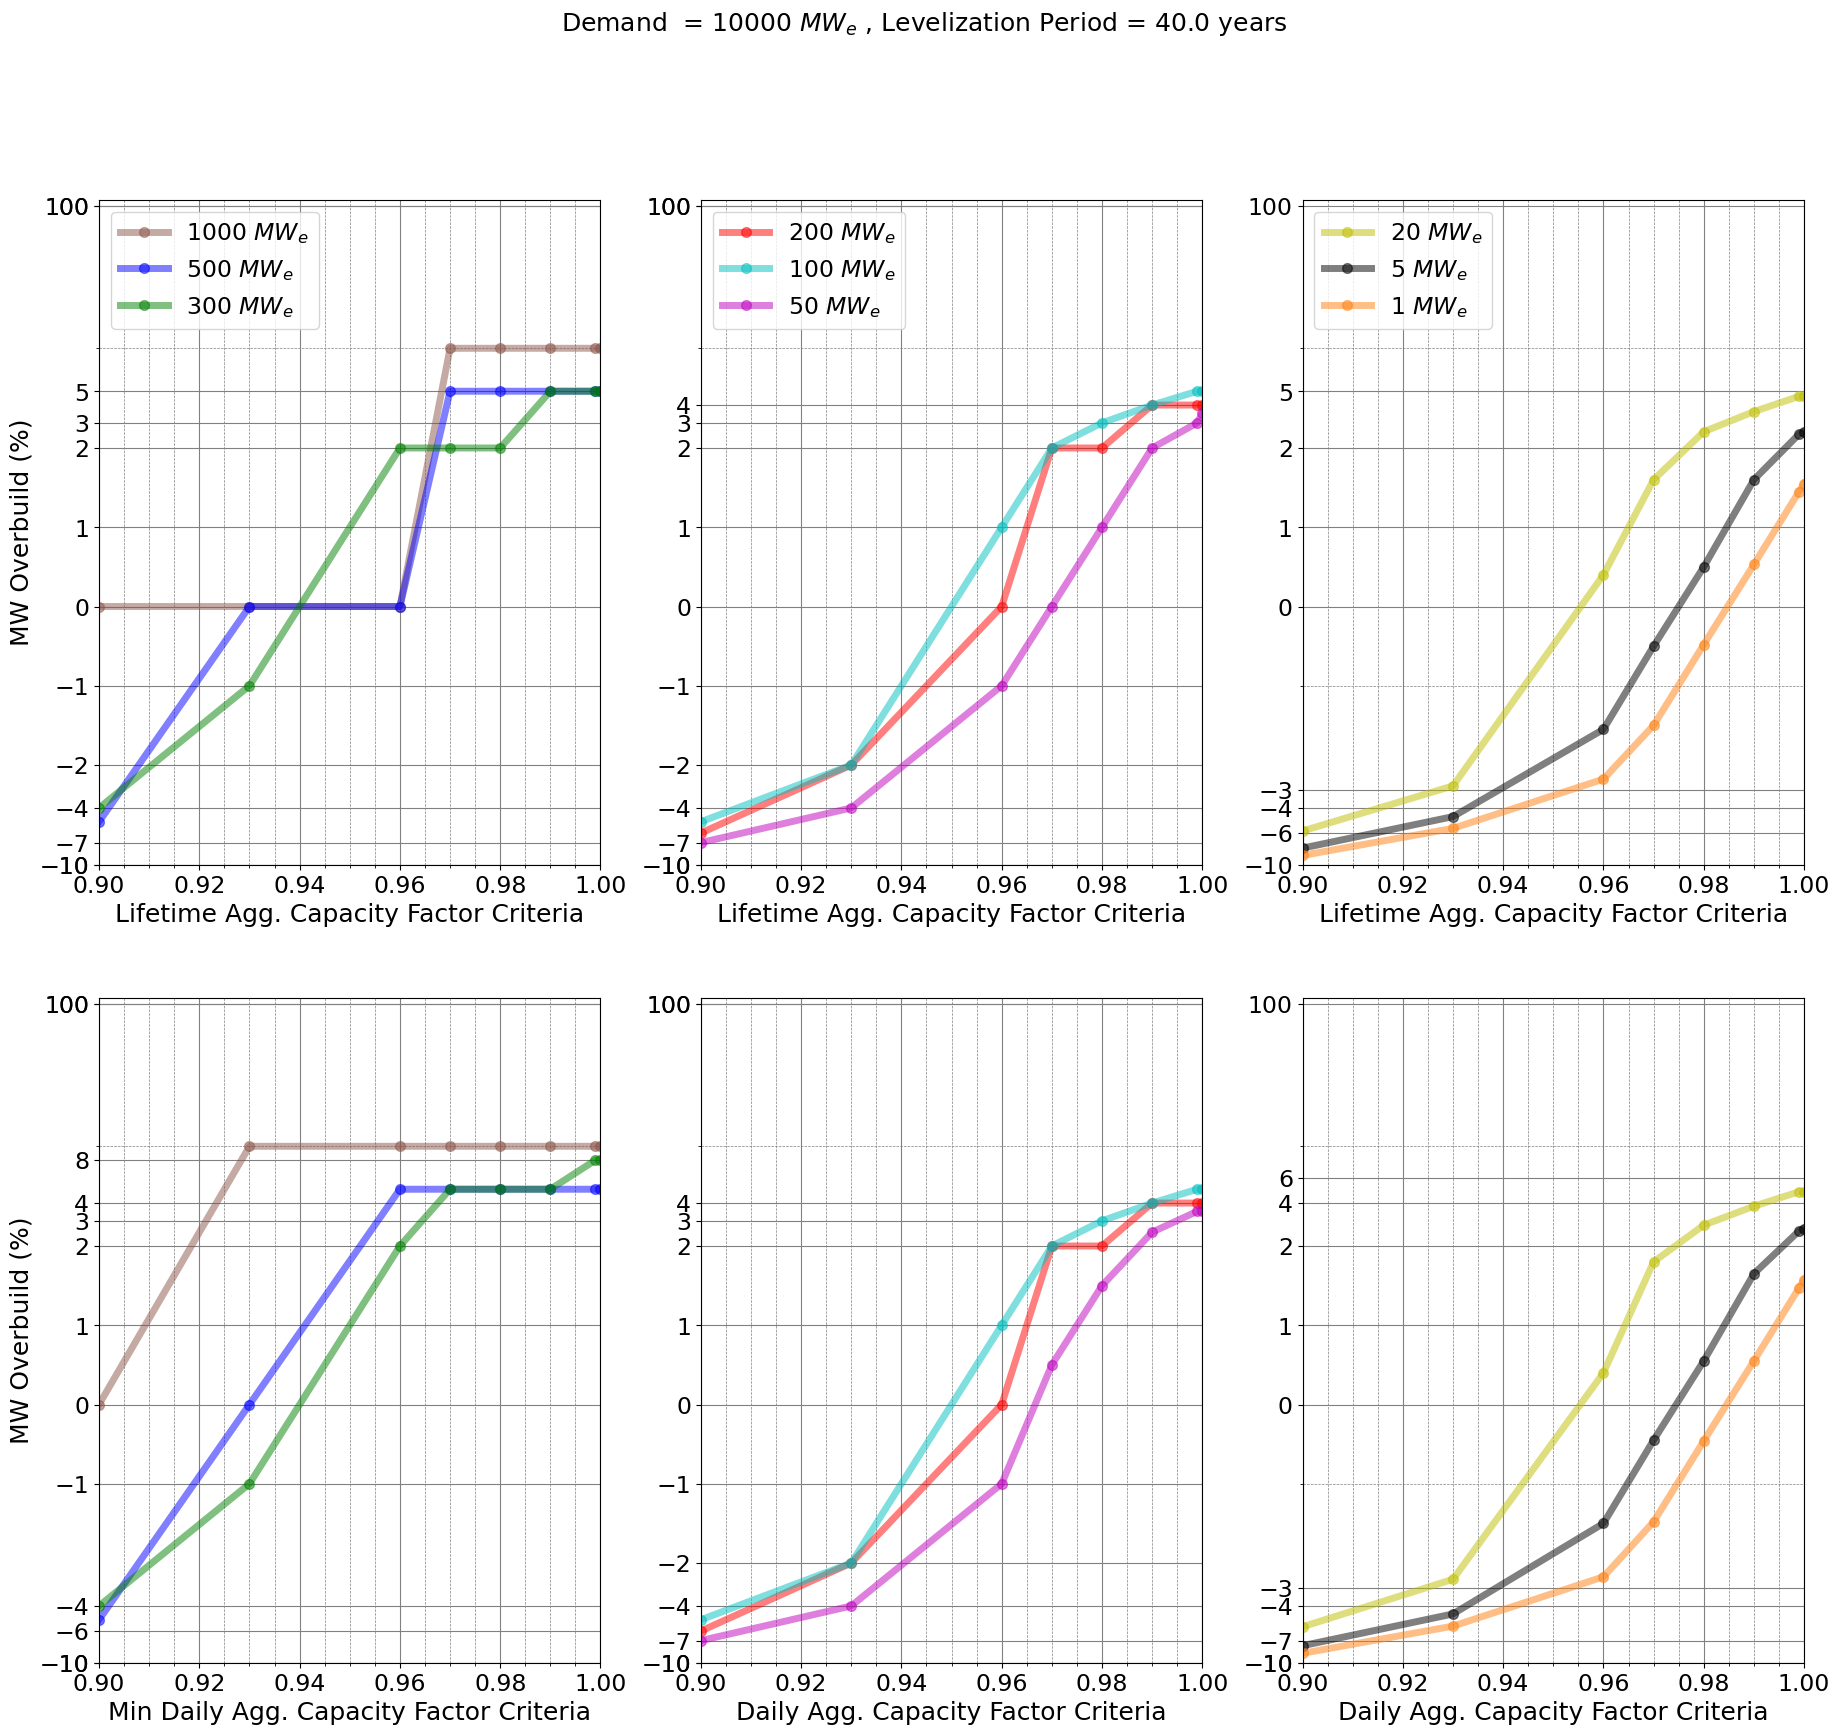

In [15]:
fig = plt.figure(figsize=(22, 19))

fig.suptitle(f"Demand  = {demand_0} $MW_e$ , Levelization Period = {np.round (levelization_period/52.1428571429, 1) } years",  fontsize=18)


plt.subplot(2,3,1)

overbuild_values = []
for i in range(3):
   
   # for the minimum daily capacity factor
   overbuild = (100*(( power_list[i] * np.array(num_R_per_capacity_factor_list_powers[i]) -  demand_0) / demand_0))
   overbuild_values.append(overbuild)
   plt.plot(capacity_factor_criteria_list, overbuild ,'-o' , markersize = 7 ,color = color_of(power_list[i]), alpha = 0.5, label =f'{power_list[i]} $MW_e$', linewidth= 5)
plt.legend(loc='upper left', fontsize= 17 )
plt.xlabel('Lifetime Agg. Capacity Factor Criteria',  fontsize=18)
plt.ylabel('MW Overbuild (%)',  fontsize=18 )
plt.yscale("symlog")

plt.grid(which='major', color='grey', linewidth=0.8)
plt.gca().yaxis.set_major_formatter(mpl.ticker.NullFormatter()) 
plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
       
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
# plt.yticks(list(set(np.hstack(overbuild_values))) + [-10, 100]) 
plt.yticks([-10, -7, -4, -2 , -1, 0, 1, 2, 3,  5, 100] + [-10, 100])

plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()




plt.yticks(fontsize=17)
plt.xticks(fontsize=17) 
plt.ylim(-10, 110)  
plt.xlim(0.9, 1)


plt.subplot(2,3,2)
overbuild_values = []
for i in range(3,6):
   
   overbuild = (100*(( power_list[i] * np.array(num_R_per_capacity_factor_list_powers[i]) -  demand_0) / demand_0))
   overbuild_values.append(overbuild)
   plt.plot(capacity_factor_criteria_list, overbuild ,'-o' , markersize = 7 ,color = color_of(power_list[i]), alpha = 0.5, label =f'{power_list[i]} $MW_e$', linewidth= 5)
plt.legend(loc='upper left', fontsize= 17 )
plt.xlabel('Lifetime Agg. Capacity Factor Criteria',  fontsize=18)
plt.yscale("symlog")

plt.grid(which='major', color='grey', linewidth=0.8)
plt.gca().yaxis.set_major_formatter(mpl.ticker.NullFormatter()) 
plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
       
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.yticks([-10, -7, -4, -2 , -1, 0, 1, 2, 3, 4, 100] + [-10, 100]) 

plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()

plt.yticks(fontsize=17)
plt.xticks(fontsize=17) 

plt.ylim(-10, 110)  
plt.xlim(0.9, 1)


plt.subplot(2,3,3)
overbuild_values = []
for i in range(6,9):

   overbuild = (100*(( power_list[i] * np.array(num_R_per_capacity_factor_list_powers[i]) -  demand_0) / demand_0))
   overbuild_values.append(overbuild)
   plt.plot(capacity_factor_criteria_list, overbuild ,'-o' , markersize = 7 ,color = color_of(power_list[i]), alpha = 0.5, label =f'{power_list[i]} $MW_e$', linewidth= 5)
plt.legend(loc='upper left', fontsize= 17  )
plt.xlabel('Lifetime Agg. Capacity Factor Criteria',  fontsize=18)
plt.yscale("symlog")

plt.grid(which='major', color='grey', linewidth=0.8)
plt.gca().yaxis.set_major_formatter(mpl.ticker.NullFormatter()) 
plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
       
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.yticks([-6,  -4, -2. -1, 0, 1, 2, 5] + [-10, 100]) 

plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()


plt.yticks(fontsize=17)
plt.xticks(fontsize=17) 

plt.ylim(-10, 110)  
plt.xlim(0.9, 1)


plt.subplot(2,3,4)
overbuild_values = []
for i in range(3):
   

   # for the minimum daily capacity factor
   overbuild_min = (100*(( power_list[i] * np.array(num_R_per_min_capacity_factor_list_powers[i]) -  demand_0) / demand_0))
   overbuild_values.append(overbuild_min)
   plt.plot(min_capacity_factor_criteria_list, overbuild_min ,'-o' , markersize = 7  ,color = color_of(power_list[i]), alpha = 0.5,label =f'{power_list[i]} $MW_e$', linewidth= 5)
   plt.xlabel('Min Daily Agg. Capacity Factor Criteria',  fontsize=18)
   plt.ylabel('MW Overbuild (%)',  fontsize=18 )
   plt.yscale("symlog")

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='major', color='grey', linewidth=0.8)
plt.gca().yaxis.set_major_formatter(mpl.ticker.NullFormatter()) 
plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
       
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.yticks([-10, -6, -4, -1, 0, 1, 2, 3, 4,8, 100] + [-10, 100]) 

plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()

plt.ylim(-10, 110)  

plt.xlim(0.9, 1)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)  


plt.subplot(2,3,5)
overbuild_values = []
for i in range(3, 6):
   

   # for the minimum daily capacity factor
   overbuild_min = (100*(( power_list[i] * np.array(num_R_per_min_capacity_factor_list_powers[i]) -  demand_0) / demand_0))
   overbuild_values.append(overbuild_min)
   plt.plot(min_capacity_factor_criteria_list, overbuild_min , '-o' , markersize = 7 , color = color_of(power_list[i]), alpha = 0.5,label =f'{power_list[i]} $MW_e$', linewidth= 5)
   plt.xlabel('Daily Agg. Capacity Factor Criteria',  fontsize=18)
   plt.yscale("symlog")

plt.grid(which='major', color='grey', linewidth=0.8)
plt.gca().yaxis.set_major_formatter(mpl.ticker.NullFormatter()) 
plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
       
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.yticks([-10, -7, -4, -2 , -1, 0, 1, 2, 3, 4, 100] + [-10, 100]) 

plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()


plt.ylim(-10, 110)  
 
plt.xlim(0.9, 1)   
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)     
   
plt.subplot(2,3,6)
overbuild_values = []
for i in range(6, 9):
   

   # for the minimum daily capacity factor
   overbuild_min = (100*(( power_list[i] * np.array(num_R_per_min_capacity_factor_list_powers[i]) -  demand_0) / demand_0))
   overbuild_values.append(overbuild_min)
   plt.plot(min_capacity_factor_criteria_list, overbuild_min , '-o' , markersize = 7  , color = color_of(power_list[i]), alpha = 0.5,label =f'{power_list[i]} $MW_e$', linewidth= 5)
   plt.xlabel('Daily Agg. Capacity Factor Criteria',  fontsize=18)
   plt.yscale("symlog")

plt.grid(which='major', color='grey', linewidth=0.8)
plt.gca().yaxis.set_major_formatter(mpl.ticker.NullFormatter()) 
plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
       
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.yticks([-10, -7, -4, -2. -1, 0, 1, 2, 4, 6] + [-10, 100]) 

plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on() 


plt.ylim(-10, 110)  

plt.xlim(0.9, 1)      

plt.yticks(fontsize=17)
plt.xticks(fontsize=17)  
plt.savefig(f'results/overbuild_{demand_0}.png', bbox_inches='tight')


plt.show()




# cost tipping points

Demand (MW) =  1000
Demand (MW) =  2000
Demand (MW) =  5000
Demand (MW) =  10000


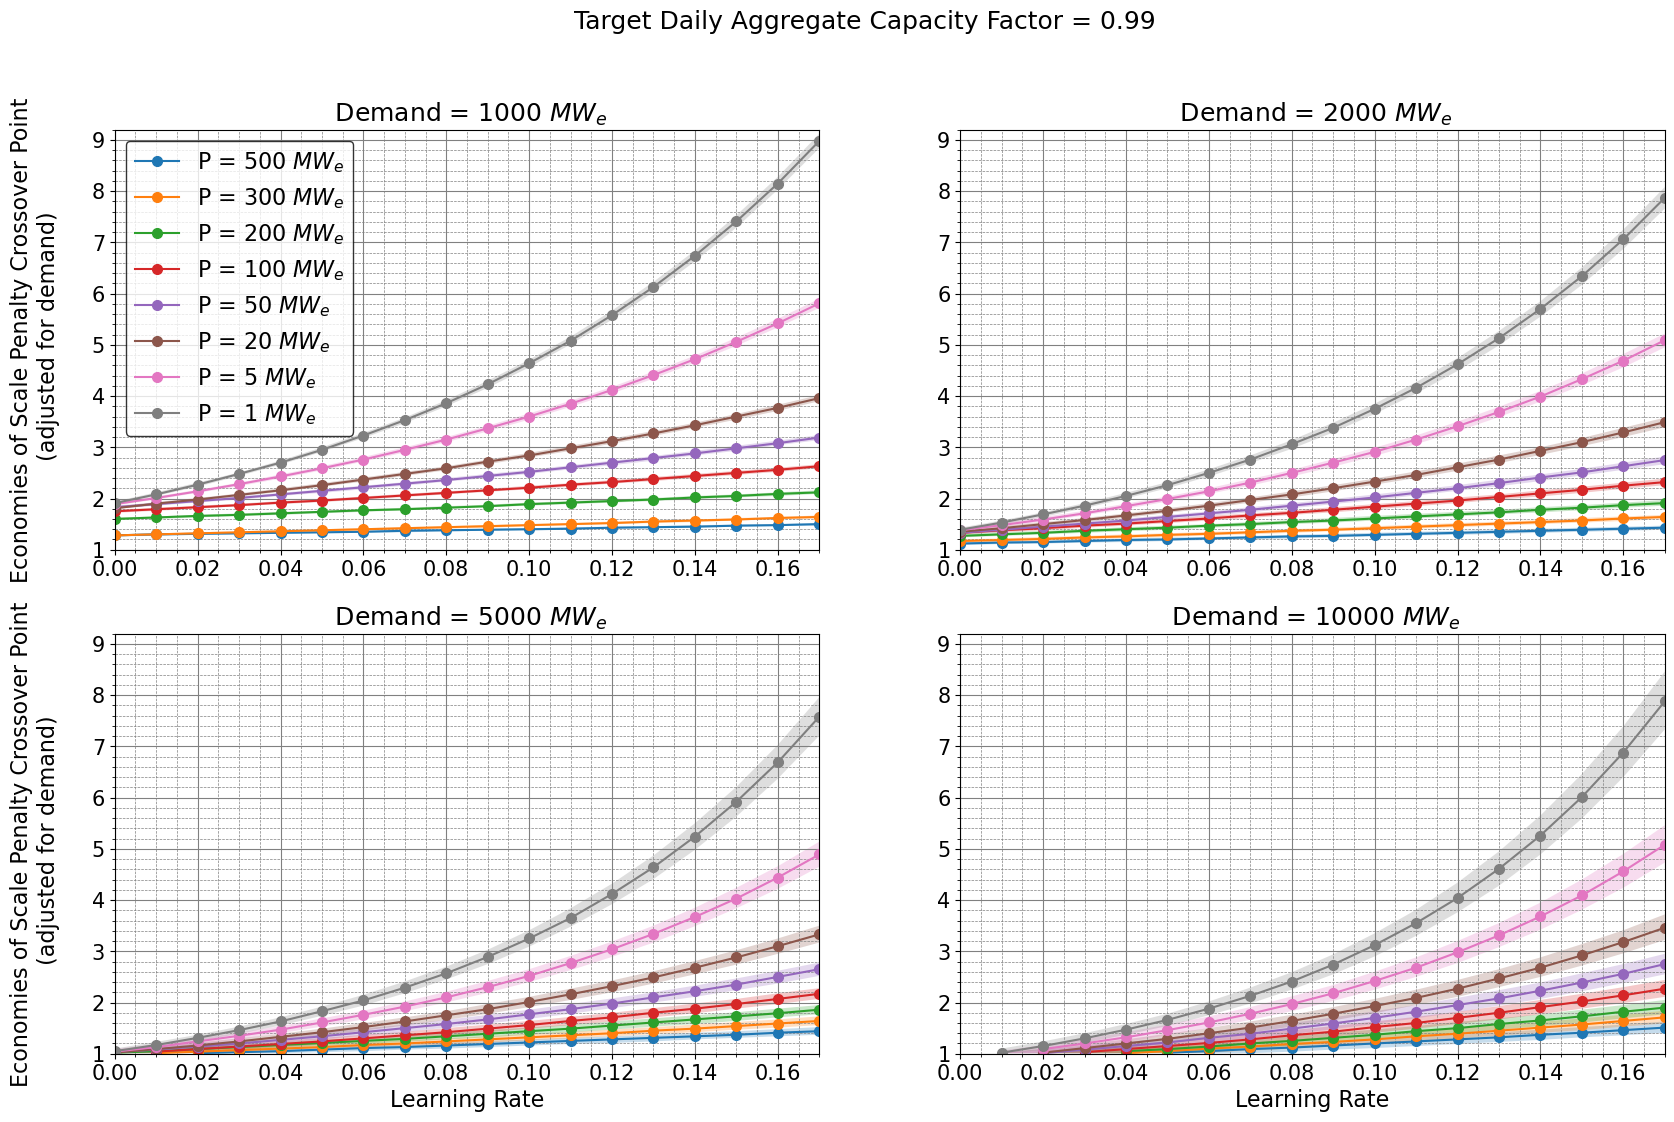

In [17]:
fig = plt.figure(figsize=(20, 12))


large_lr_avg = LR_for_power(power_large_ref ) 
large_lr_std = 0.03
large_lr_lo = large_lr_avg - large_lr_std
large_lr_hi = large_lr_avg + large_lr_std
  
levelization_period_0 = int(np.ceil((40*365)/7))# 30 years   

overall_capacity_factor_criteria = 0 # has no effect
min_capacity_factor_criteria     = 0.99  

fig.suptitle(f"Target Daily Aggregate Capacity Factor = {min_capacity_factor_criteria }",  fontsize=18)  
    
large_reactor_ref_power = power_large_ref # This is the average power in the GAIN metanalaysis report (and i rouneded it)    

lr_min = 0
lr_max = 0.17

pwr_list = [500 ,  300 , 200, 100  ,50, 20, 5, 1]

lr_interval   = 0.01

num_LR_small = 1+int(np.ceil( (lr_max - lr_min )/ lr_interval) )

ref_large_reactor_cost_per_kw = 1 # the cost here does not matter because we calculate ratios
min_cost_small = ref_large_reactor_cost_per_kw
max_cost_small = 10 *min_cost_small 

cost_interval = 0.01

num_cost     = 1 + int(np.ceil( ( max_cost_small - min_cost_small )/ cost_interval) )


demand_list = [1000, 2000, 5000, 10000]

for i in range (len(demand_list)):
    demand = demand_list[i]
    plt.subplot(2,2,i+1)
    
    print("Demand (MW) = ", demand)    
     

    for power in pwr_list:
        
        fuel_lifetime_small = fuel_cycle_length(power) 
        refueling_period_small = refueling_duration_estimate(power)

        
        lr_small_list = []
        lr_small_list1 = []
        breakeven_points_0_list = []
        breakeven_points_1_list = []
        avg_point_list = []
        
        num_large_reactors = int(np.ceil(num_reactors_needed_for_capacity_factor_weeks_apprioach(overall_capacity_factor_criteria, min_capacity_factor_criteria, large_reactor_ref_power ,levelization_period_0, demand)))

        num_small_reactors =  int(np.ceil(num_reactors_needed_for_capacity_factor_weeks_apprioach(overall_capacity_factor_criteria,\
                min_capacity_factor_criteria , power ,\
                    levelization_period_0, demand)))
        
        for lr_small in np.linspace(lr_min,lr_max ,num_LR_small) :
        
            try:
                breakeven_points = calculate_break_even_cost_for_lr_per_demand(lr_small, large_lr_lo, large_lr_hi,\
        ref_large_reactor_cost_per_kw, num_large_reactors,  num_small_reactors, min_cost_small, max_cost_small,\
            num_cost, demand, large_reactor_ref_power, power)
                
                
                lr_small_list.append(lr_small)
                breakeven_points_0_list.append(breakeven_points[0])
                breakeven_points_1_list.append(breakeven_points[1])
                
            except:
                ...

            try:
                # For the 8% avg LR for the large reactor
                avg_point = calculate_break_even_cost_for_lr_per_demand(lr_small, large_lr_avg, large_lr_avg,\
        ref_large_reactor_cost_per_kw, num_large_reactors,  num_small_reactors, min_cost_small, max_cost_small,\
            num_cost, demand, large_reactor_ref_power, power)
                
                avg_point_list.append(avg_point[0])
                lr_small_list1.append(lr_small)
            except:
                ...
                
        plt.fill_between(lr_small_list, breakeven_points_0_list , breakeven_points_1_list, alpha=0.25)  
        plt.plot(lr_small_list1, avg_point_list,  '-o' , markersize = 7,label = f"P = {int(power)} $MW_e$")     

    if demand == 1000:
        plt.legend( loc='upper left', fontsize=16, edgecolor='black', fancybox=True)   # bbox_to_anchor=(1.05, 1.0)

    plt.grid(which='major', color='grey', linewidth=0.8)
    plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
    plt.minorticks_on()
    if demand == 5000 or demand == 10000:
        plt.xlabel('Learning Rate', fontsize=16) 
    
    if demand == 1000 or demand == 5000:
        plt.ylabel('Economies of Scale Penalty Crossover Point\n (adjusted for demand)\n', fontsize=16)  

    plt.ylim(1, 9.2 )
    plt.xlim(0, lr_max ) 
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)

    plt.title(f" Demand = {demand} $MW_e$" , fontsize=18)
    
    plt.savefig(f'results/lr_vs_costTipping_adjustedForDemand_{demand}.png', bbox_inches='tight')

plt.show()     

# $ \textnormal {Economies of Scale Penalty Crossover Point} = f(capacity factor, Demand, Power)$
## Learning rate is reflected in the uncertainty

In [18]:
ref_large_reactor_cost_per_kw = 1 # just for ratios
large_reactor_ref_power = 1000

large_lr_avg  = LR_for_power(power_large_ref) 
large_lr_std =  0.03
small_lr_std = large_lr_std 

large_lr_lo = large_lr_avg - large_lr_std
large_lr_hi = large_lr_avg + large_lr_std
levelization_period_0 = int(np.ceil((40*365)/7))# 30 years   
overall_capacity_factor_criteria = 0 # has no effect
min_capacity_factor_criteria=  0.99
demand_list = [1000, 2000, 5000, 10000]

min_cost_small = ref_large_reactor_cost_per_kw
cost_interval = 0.01
max_cost_small = 12 * ref_large_reactor_cost_per_kw
num_cost     = 1 + int(np.ceil( ( max_cost_small - min_cost_small )/ cost_interval) )
lr_interval   = 0.01

pwr_list =  [500 , 300, 200, 100, 50, 20, 5, 1]


# save to list of lists
cost_tipping_2_lo_list_tot = []
cost_tipping_3_hi_list_tot= []
cost_tipping_1_low_list_tot= []
cost_tipping_1_hi_list_tot= []
avg_cost_tipping_list_tot= []
                                         
                                         
for ii in range(len(pwr_list)):
    power = pwr_list[ii]
    
    # for smaller reactors
    small_lr_avg = LR_for_power(power) # LR as a function of power
    
    small_lr_lo = small_lr_avg  - small_lr_std
    small_lr_hi = small_lr_avg  + small_lr_std
        
    
    print("Power (MW) = ",power)

    breakeven_point_0_list = []
    breakeven_point_1_list = []
    
    avg_cost_tipping_list = []
    cost_tipping_1_low_list = []
    cost_tipping_1_hi_list = []
    cost_tipping_2_lo_list = []
    cost_tipping_3_hi_list = []
     
    
            
    for demand in demand_list :
        
        num_large_reactors = int(np.ceil(num_reactors_needed_for_capacity_factor_weeks_apprioach(overall_capacity_factor_criteria, min_capacity_factor_criteria, large_reactor_ref_power,\
            levelization_period_0, demand)))

        num_small_reactors =  int(np.ceil(num_reactors_needed_for_capacity_factor_weeks_apprioach(overall_capacity_factor_criteria,\
                min_capacity_factor_criteria , power ,\
                    levelization_period_0, demand)))
        
         
        

    
        # This is based on avg lr for small reactor and also average LR for large reactor
        avg_cost_tipping = (calculate_break_even_cost_for_lr_per_demand(small_lr_avg, large_lr_avg, large_lr_avg, ref_large_reactor_cost_per_kw ,\
                                     num_large_reactors,  num_small_reactors, min_cost_small, max_cost_small, num_cost, demand, large_reactor_ref_power, power))[0]
        avg_cost_tipping_list.append(avg_cost_tipping)

        # lets add the uncertainty because of the learning rate of the large reactors
        cost_tipping_1 = (calculate_break_even_cost_for_lr_per_demand(small_lr_avg, large_lr_lo, large_lr_hi, ref_large_reactor_cost_per_kw ,\
                                     num_large_reactors,  num_small_reactors, min_cost_small, max_cost_small, num_cost, demand, large_reactor_ref_power, power))
        cost_tipping_1_low_list.append(cost_tipping_1[0])
        cost_tipping_1_hi_list.append(cost_tipping_1[1])
    
        # if the LR of the small reactor is low
        cost_tipping_2 = (calculate_break_even_cost_for_lr_per_demand(small_lr_lo, large_lr_lo, large_lr_hi, ref_large_reactor_cost_per_kw ,\
                                     num_large_reactors,  num_small_reactors, min_cost_small, max_cost_small, num_cost, demand, large_reactor_ref_power, power))
        # we take the lower bound here (because this is lowest ever)
        cost_tipping_2_lo_list.append(min(cost_tipping_2))
        
        # if the LR of the small reactor is high
        cost_tipping_3 = (calculate_break_even_cost_for_lr_per_demand(small_lr_hi, large_lr_lo, large_lr_hi, ref_large_reactor_cost_per_kw ,\
                                     num_large_reactors,  num_small_reactors, min_cost_small, max_cost_small, num_cost, demand, large_reactor_ref_power, power))
        # we take the upper bound here (because this is highest ever)
        cost_tipping_3_hi_list.append(max(cost_tipping_3))
        
        
    # save to list of lists
    cost_tipping_2_lo_list_tot.append(cost_tipping_2_lo_list)
    cost_tipping_3_hi_list_tot.append(cost_tipping_3_hi_list)
    cost_tipping_1_low_list_tot.append(cost_tipping_1_low_list)
    cost_tipping_1_hi_list_tot.append(cost_tipping_1_hi_list)
    avg_cost_tipping_list_tot.append(avg_cost_tipping_list
                                         )
  





        


Power (MW) =  500
Power (MW) =  300
Power (MW) =  200
Power (MW) =  100
Power (MW) =  50
Power (MW) =  20
Power (MW) =  5
Power (MW) =  1


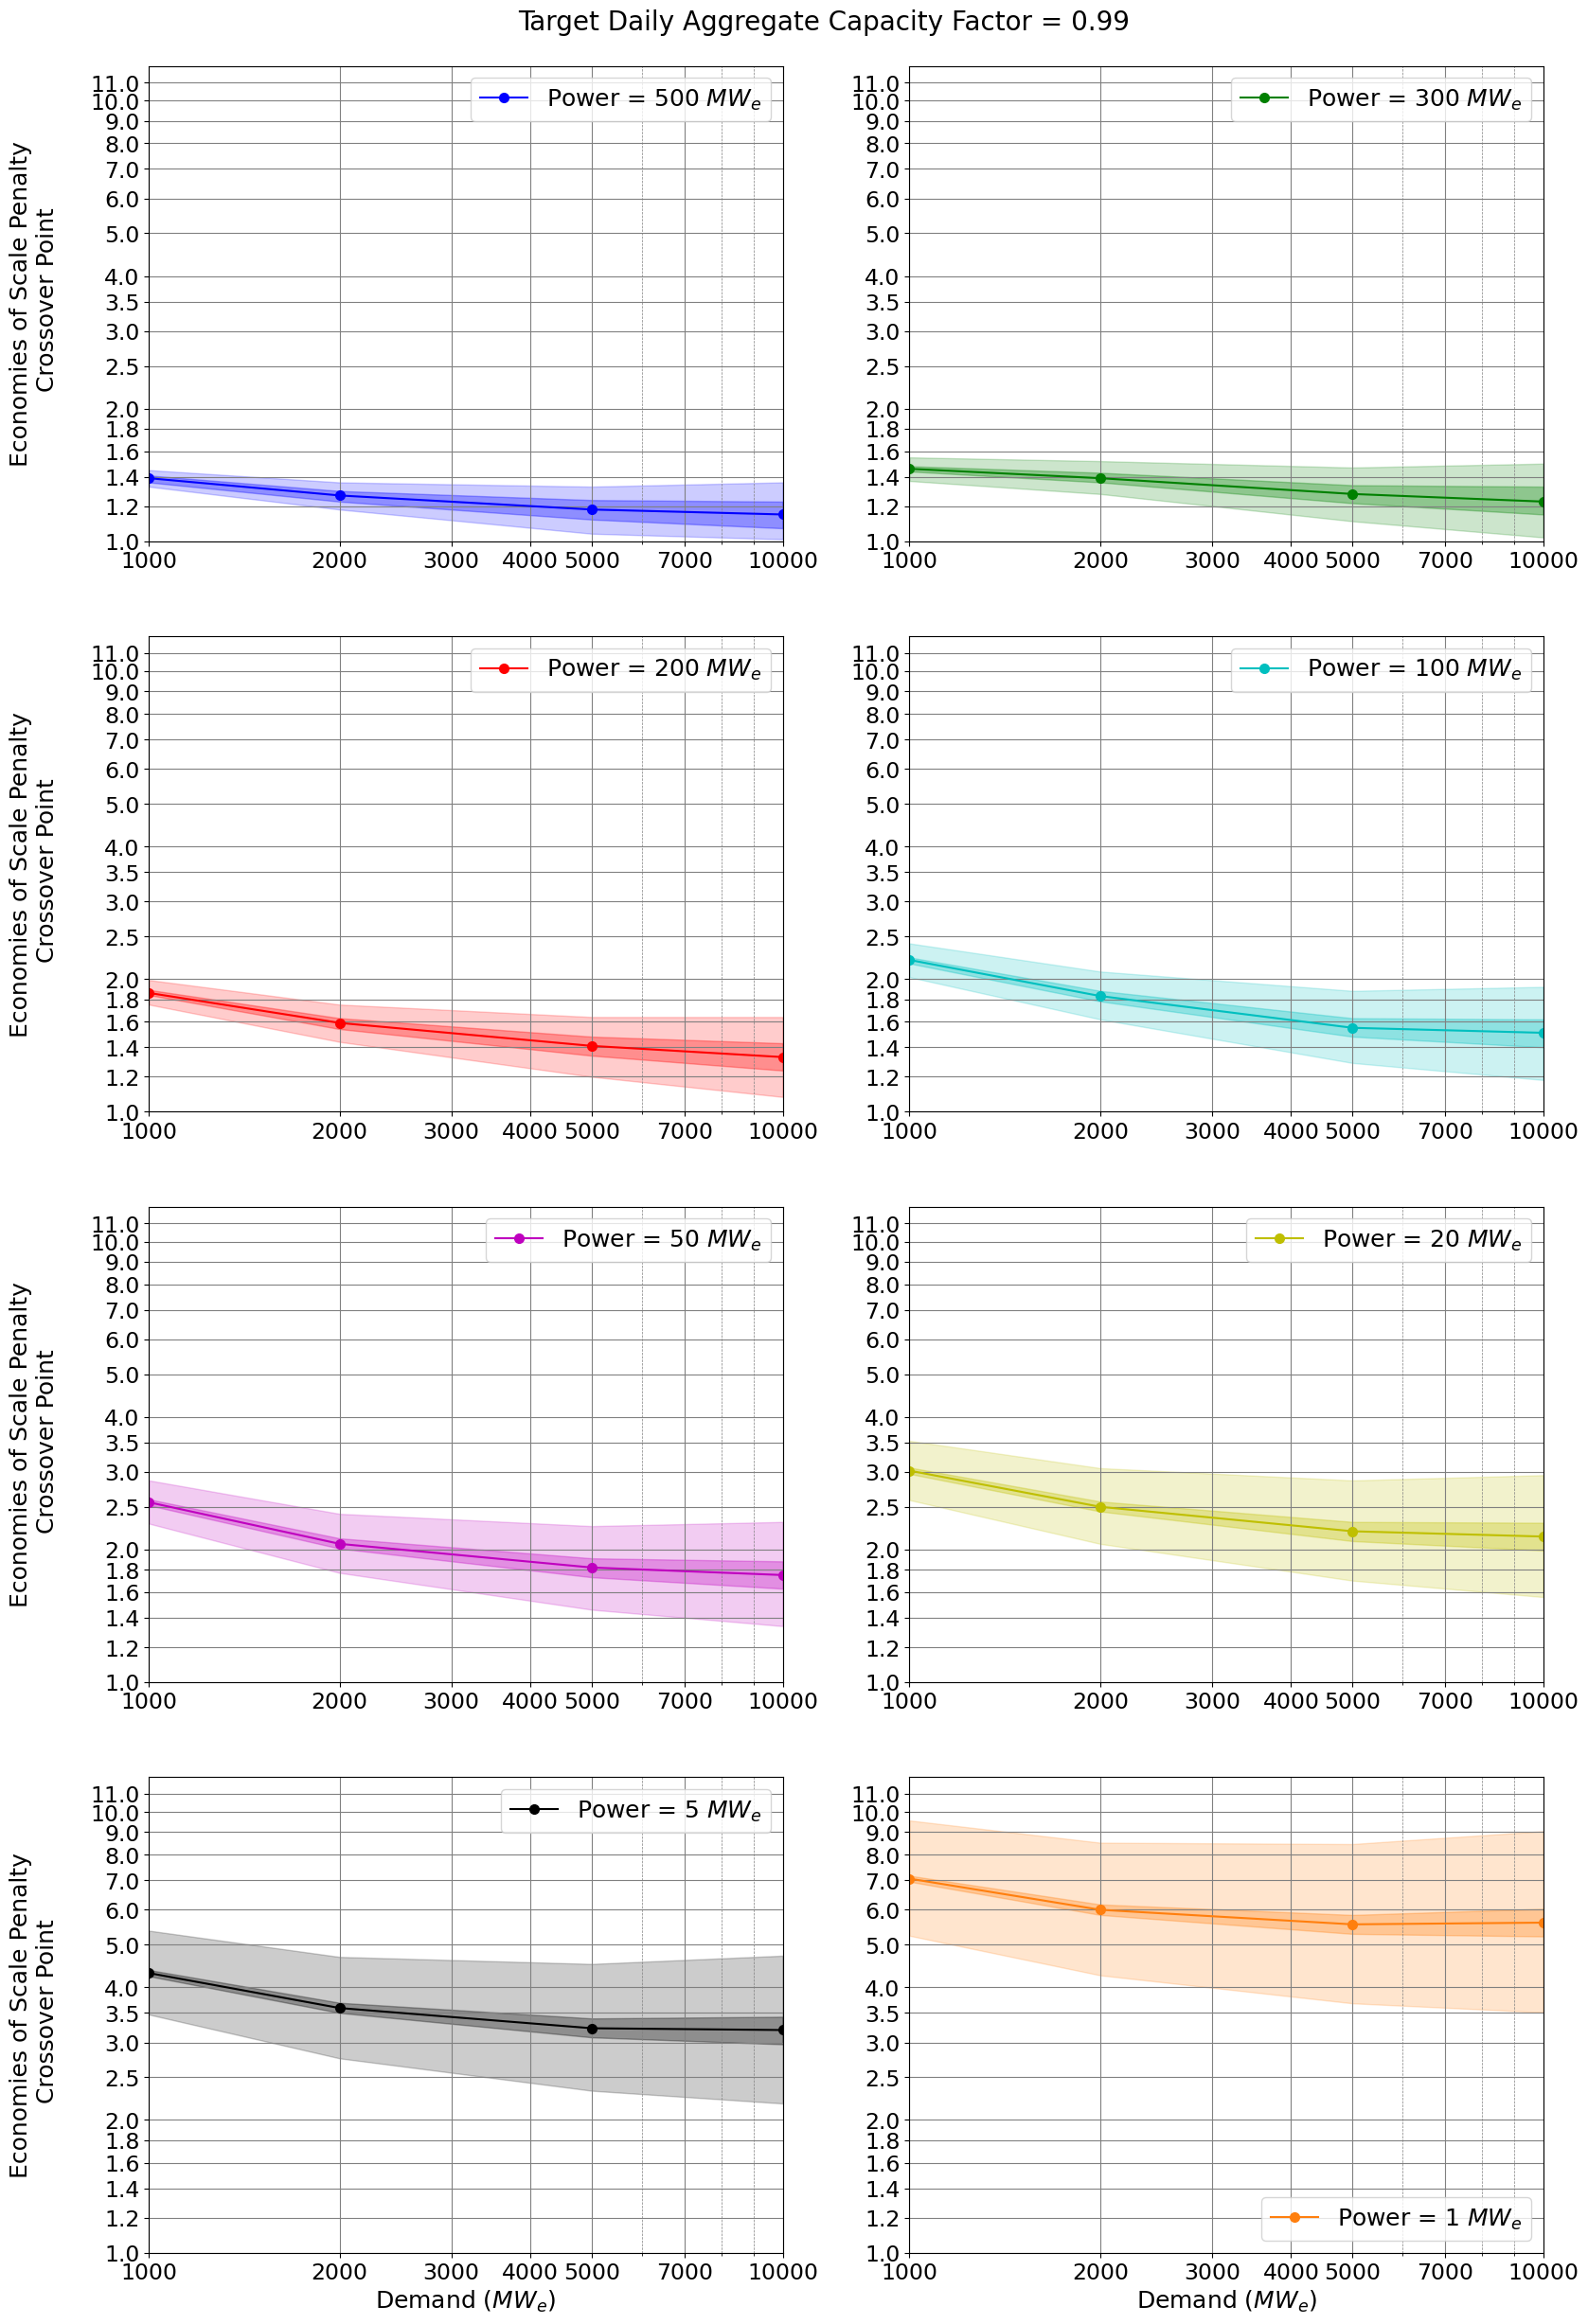

In [19]:
fig = plt.figure(figsize=(19, 30))
fig.suptitle(f"Target Daily Aggregate Capacity Factor = {min_capacity_factor_criteria}", y = 0.9, fontsize=20)

for ii in range(len(pwr_list)):
    power = pwr_list[ii]
    plt.subplot(4, 2, ii+1)
    
    plt.fill_between(demand_list, cost_tipping_2_lo_list_tot[ii], cost_tipping_3_hi_list_tot[ii], alpha=0.2, color =  color_of(power))
    plt.fill_between(demand_list, cost_tipping_1_low_list_tot[ii], cost_tipping_1_hi_list_tot[ii], alpha=0.3, color =  color_of(power)) 
    plt.plot(demand_list, avg_cost_tipping_list_tot[ii]  , '-o' , markersize = 7 , label = f"Power = {int(power)} $MW_e$", color =  color_of(power)) 
    if power == 1:
        plt.legend( loc='lower right', fontsize=18)   # bbox_to_anchor=(1.05, 1.0) #  edgecolor='black'
    else:
        plt.legend( loc='upper right', fontsize=18) 
            
    plt.yscale("log")
    plt.xscale("log")
    plt.xlim(1000, 10000)
    plt.ylim(1, 12)
    
    plt.grid(which='major', color='grey', linewidth=0.8)
    
    plt.gca().yaxis.set_major_formatter(mpl.ticker.NullFormatter()) 
    plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    plt.gca().xaxis.set_major_formatter(mpl.ticker.NullFormatter()) 
    plt.gca().xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
       
    

    plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    
    plt.yticks( [1, 1.2, 1.4, 1.6, 1.8, 2, 2.5, 3, 3.5, 4, 5, 6, 7, 8, 9, 10, 11])
    plt.xticks( [1000, 2000, 3000, 4000, 5000, 7000, 10000])
    plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
    plt.minorticks_on()
    
    if power in [ 5, 1]:
        plt.xlabel('Demand ($MW_e$)', fontsize=18) 
    if power in [500, 200, 50, 5]:
        plt.ylabel('Economies of Scale Penalty\n Crossover Point\n', fontsize=18)  
    
    plt.yticks(fontsize=17)
    plt.xticks(fontsize=17)
    
    


# A schedule for a mix of reactors

In [20]:
power_list1 = [500, 1, 50, 1000, 200,  50, 20, 5, 300, 500]
schedule_mix_1 = optimize_schedule(power_list1 , 2*520 )



 The difference between prediction and desired output is 0 : 1626 vs. 1626 Total MW

It takes 4.99 years to startup up all the reactors



 The schedule optimizatation ends


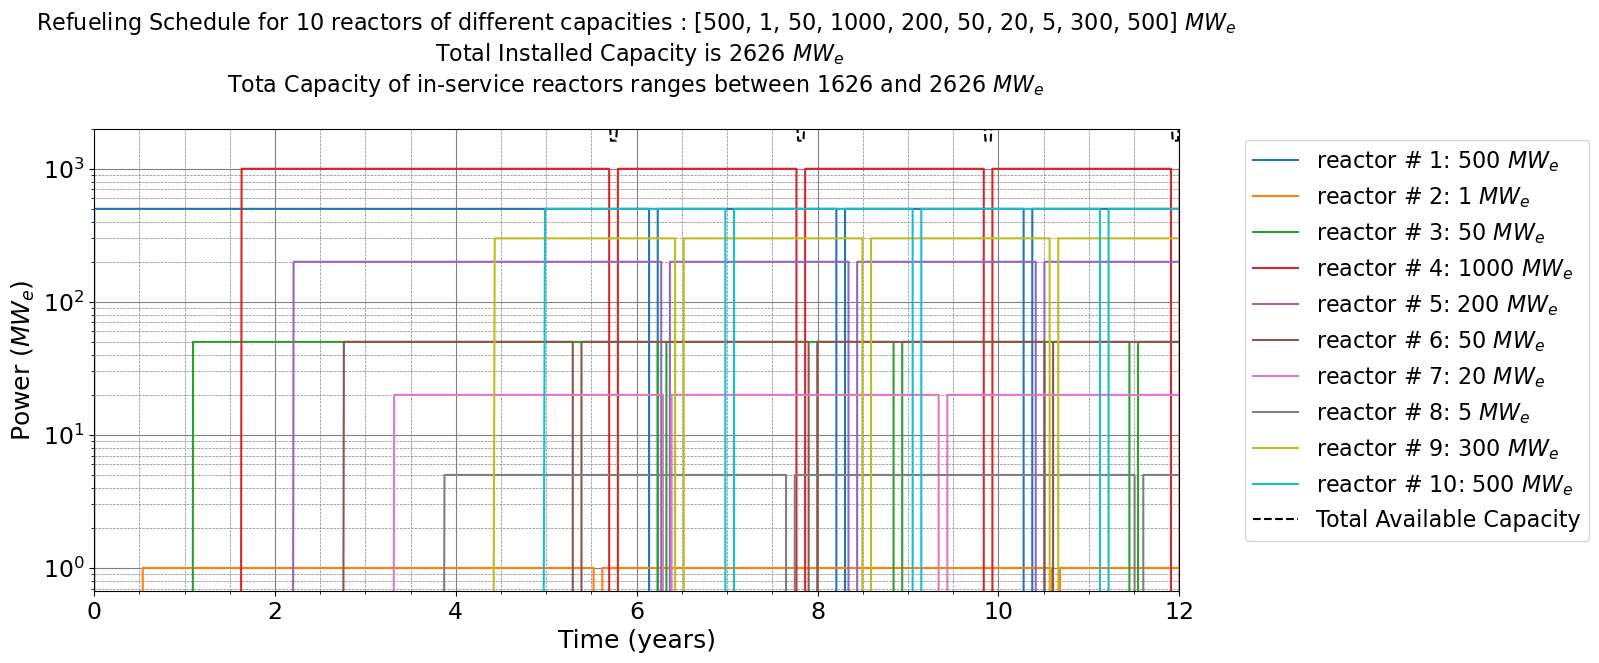

In [21]:
times = np.array(schedule_mix_1[0])
power_array = np.vstack(schedule_mix_1[1])
num_cols = power_array.shape[1]
delays = schedule_mix_1[3]


fig = plt.figure(figsize=(14, 6))


for i in range((num_cols )):
    times1 =np.append(0,delays[i] )
    times11 = np.append(times1 , times)
    power_array_i = np.append( 0 , power_list1[i]) # , power_array[:, i])
    power_array_ii = np.append( power_array_i, power_array[:, i])
    plt.plot(times11/(52.1428571429), power_array_ii, label = f"reactor # {i+1}: { power_list1[i]} $MW_e$")

available_power_list = [] 
for row in power_array:
    sum_powers = (sum(row))
    available_power_list.append(sum_powers)


# plt.plot(times/52.1428571429, [sum(power_list1) ] *times.shape[0] , color = "k", label = f"Total Installed Capacity: {sum(power_list1) } $MW_e$")
plt.plot(times/52.1428571429,  available_power_list ,linestyle='dashed' ,color = "k", label = "Total Available Capacity")

plt.yscale('log')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize = 16)


plt.xlabel('Time (years)', fontsize= 18) 
plt.ylabel('Power ($MW_e$)', fontsize=18) 

plt.title(f"Refueling Schedule for {num_cols} reactors of different capacities : {power_list1 } $MW_e$\n Total Installed Capacity is {sum(power_list1)} $MW_e$ \nTota Capacity of in-service reactors ranges between {min(available_power_list)} and {max(available_power_list)} $MW_e$ \n", fontsize=16)
plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
plt.xlim(0, 12) 
plt.ylim(0, 2000)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)

plt.savefig(f'schedule_mix1.png', bbox_inches='tight')

plt.show()

# print( "startup period  = ", initial_delay_list[-1], "weeks")